In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
UFC = pd.read_csv('Data/2a) UFC Fights.csv')

#make sure theres no space in the columns
UFC.columns = [c.replace(' ', '_') for c in UFC.columns]

#change outcome win = 1, everything else 0
UFC['OUTCOME1'] = UFC.OUTCOME.map({'win':1, 'loss':0, 'draw':0, 'NC':0})

#change stance and stance_diff into 1,0
#lets just put orthodox as 1, other as 0
UFC['STANCE1'] = UFC.STANCE.map({'Orthodox':1, 'Southpaw':0, 'Switch':0, 'Open Stance':0,'Sideways':0})
#same stance = 0
UFC['STANCE_DIFF1'] = UFC.STANCE_DIFF.map({'Same Stance':0, 'Different Stance':1})

#Try using more stance information
# create a DataFrame with the four dummy variable columns
STANCE_dummies = pd.get_dummies(UFC.STANCE, prefix='STANCE').iloc[:, 1:]
#STANCE_dummies
UFC = pd.concat([UFC, STANCE_dummies], axis=1)

#Stance information works well, but it looksl ike southpaw is a great advantage. Group observations into southpaw = 1
#Other = 0
UFC['STANCE2'] = UFC.STANCE.map({'Orthodox':0, 'Southpaw':1, 'Switch':0, 'Open Stance':0,'Sideways':0})

In [3]:
#Add Business Filters - JUST TAKE WIN OBSERVATIONS
#Exclude fights where it is single round only
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')]

#see how many fights are there for each weight class
#print UFC1.WEIGHT_CLASS.value_counts()

#from initial investigation we will exclude Women's classes, Catch Weight and Super Heavyweight
UFC1=UFC[(UFC.ROUND_FORMAT == 'MULTI-ROUND')&(UFC.OUTCOME1==1)&(-UFC.WEIGHT_CLASS.isin(['Super Heavyweight','Catch Weight','Womens Bantamweight','Womens Strawweight']))&(UFC.WEIGHT_CLASS.notnull())]
print UFC1.WEIGHT_CLASS.value_counts()
print UFC1.columns

Lightweight          703
Welterweight         693
Middleweight         542
Light Heavyweight    356
Heavyweight          333
Featherweight        265
Bantamweight         211
Flyweight            105
Name: WEIGHT_CLASS, dtype: int64
Index([u'FIGHT_ORDER', u'KEY', u'ROUND_FORMAT', u'EVENT_TYPE', u'EVENT_NAME',
       u'EVENT_YEAR', u'EVENT_MONTH', u'EVENT_DAY', u'LOCATION_COUNTRY',
       u'LOCATION_CITY', u'VENUE', u'ATTENDANCE', u'MAIN_FIGHT', u'MID',
       u'WEIGHT_CLASS', u'REF', u'METHOD', u'METHOD_D', u'ROUND',
       u'FINISH_ROUND_MIN', u'FINISH_ROUND_SEC', u'FINISH_ROUND_INSECONDS',
       u'TOTAL_INSECONDS', u'FIGHTER_NAME', u'FIGHER_NO', u'OUTCOME',
       u'FIGHTER_ID', u'STR', u'TD', u'SUB', u'PASS', u'NICK', u'ASSOCIATION',
       u'LOCALITY', u'COUNTRY', u'BIRTH_YEAR', u'AGE_AT_FIGHT', u'HEIGHT_CM',
       u'WEIGHT_KG', u'REACH_INCH', u'REACH_INCH1', u'STANCE', u'WIN_AT_FIGHT',
       u'NOTWIN_AT_FIGHT', u'TOTAL_AT_FIGHT', u'WINRATIO_AT_FIGHT',
       u'STRAVG_AT_FIGHT',

(3208, 37)
(2470, 37)


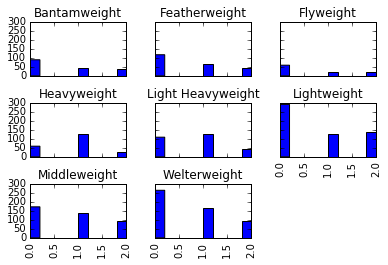

In [4]:
#drop everything except the variables we want keep - building only a Diff Model
#UFC1b = UFC1.iloc[:,[11,12,13,14,16,17,22,25,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49]]
UFC1b = UFC1.iloc[:,[11,12,13,14,16,17,22,25,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,69]]
print UFC1b.shape
#print UFC1b.head(5)
#dropping any missing observations
UFC1b = UFC1b.dropna()
print UFC1b.shape

UFC1b['METHOD1'] = UFC.METHOD.map({'Decision':0, 'TKO':1, 'Submission':2, 'KO':1,'DQ':0})
UFC1b.METHOD1.hist(by=UFC1b.WEIGHT_CLASS, sharex=True, sharey=True)
plt.show()

In [27]:
#Light Tree Model

CLASS = 'Flyweight','Bantamweight','Featherweight',
feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[2,6,9,10,11,13,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,34,36]]
X = feature_cols
y = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].METHOD1

#split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Fit the decision tree classifier
ctree = tree.DecisionTreeClassifier(random_state=1, max_depth=2)
ctree.fit(X_train, y_train)

# Clean up the output
features = X_train.columns.tolist()
print pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

# Make predictions on the test set
preds = ctree.predict(X_test)
print metrics.accuracy_score(y_test, preds)

# Confusion matrix
print pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict(X_test)

                        0         1
1         TOTAL_INSECONDS  0.916480
10        SUBAVG_AT_FIGHT  0.060416
0                     MID  0.023104
13            HEIGHT_DIFF  0.000000
21            REACH_DIFF1  0.000000
20          WINRATIO_DIFF  0.000000
19  PASSAVG_AT_FIGHT_DIFF  0.000000
18   SUBAVG_AT_FIGHT_DIFF  0.000000
17    TDAVG_AT_FIGHT_DIFF  0.000000
16   STRAVG_AT_FIGHT_DIFF  0.000000
15               EXP_DIFF  0.000000
14            WEIGHT_DIFF  0.000000
11       PASSAVG_AT_FIGHT  0.000000
12               AGE_DIFF  0.000000
9          TDAVG_AT_FIGHT  0.000000
8         STRAVG_AT_FIGHT  0.000000
7       WINRATIO_AT_FIGHT  0.000000
6          TOTAL_AT_FIGHT  0.000000
5             REACH_INCH1  0.000000
4               WEIGHT_KG  0.000000
3               HEIGHT_CM  0.000000
2            AGE_AT_FIGHT  0.000000
22                STANCE2  0.000000
0.764227642276
predicted   0   1   2
actual               
0          59   0   0
1           1  22   8
2           3  17  13


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [6]:
#predictions - Light
print ctree.predict_proba([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])
print ctree.predict([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])

[[ 0.  1.  0.]]
[ 1.]


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


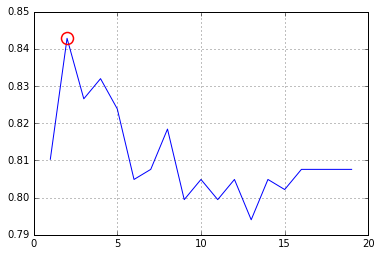

In [28]:
#Grid Search for best depth - Light
from sklearn.grid_search import GridSearchCV
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5)
grid.fit(X_train, y_train)
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [23]:
#Middle Tree Model

CLASS = 'Lightweight','Welterweight',
feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[2,6,9,10,11,13,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,34,36]]
X = feature_cols
y = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].METHOD1

#split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the decision tree classifier
ctree = tree.DecisionTreeClassifier(random_state=42, max_depth=3)
ctree.fit(X_train, y_train)

# Clean up the output
features = X_train.columns.tolist()
print pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

# Make predictions on the test set
preds = ctree.predict(X_test)
print metrics.accuracy_score(y_test, preds)

# Confusion matrix
print pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict(X_test)

                        0         1
1         TOTAL_INSECONDS  0.971313
18   SUBAVG_AT_FIGHT_DIFF  0.027663
17    TDAVG_AT_FIGHT_DIFF  0.001024
0                     MID  0.000000
12               AGE_DIFF  0.000000
21            REACH_DIFF1  0.000000
20          WINRATIO_DIFF  0.000000
19  PASSAVG_AT_FIGHT_DIFF  0.000000
16   STRAVG_AT_FIGHT_DIFF  0.000000
15               EXP_DIFF  0.000000
14            WEIGHT_DIFF  0.000000
13            HEIGHT_DIFF  0.000000
11       PASSAVG_AT_FIGHT  0.000000
10        SUBAVG_AT_FIGHT  0.000000
9          TDAVG_AT_FIGHT  0.000000
8         STRAVG_AT_FIGHT  0.000000
7       WINRATIO_AT_FIGHT  0.000000
6          TOTAL_AT_FIGHT  0.000000
5             REACH_INCH1  0.000000
4               WEIGHT_KG  0.000000
3               HEIGHT_CM  0.000000
2            AGE_AT_FIGHT  0.000000
22                STANCE2  0.000000
0.756457564576
predicted    0   1   2
actual                
0          130   0   1
1            0  48  39
2            0  26  27


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [24]:
#predictions - Middle
print ctree.predict_proba([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])
print ctree.predict([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])

[[ 0.00581395  0.37209302  0.62209302]]
[ 2.]


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


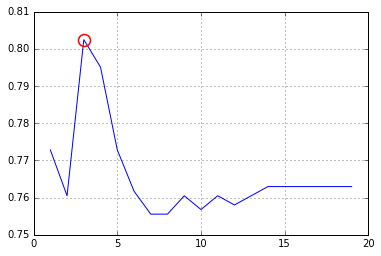

In [25]:
#Grid Search for best depth - Middle
from sklearn.grid_search import GridSearchCV
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5)
grid.fit(X_train, y_train)
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

In [21]:
#Heavy Tree Model

CLASS = 'Middleweight','Light Heavyweight','Heavyweight',
feature_cols = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].iloc[:,[2,6,9,10,11,13,17,18,19,20,21,22,23,24,25,27,28,29,30,31,32,34,36]]
X = feature_cols
y = UFC1b[(UFC1b.WEIGHT_CLASS.isin(CLASS))].METHOD1

#split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the decision tree classifier
ctree = tree.DecisionTreeClassifier(random_state=42, max_depth=5)
ctree.fit(X_train, y_train)

# Clean up the output
features = X_train.columns.tolist()
print pd.DataFrame(zip(features, ctree.feature_importances_)).sort_index(by=1, ascending=False)

# Make predictions on the test set
preds = ctree.predict(X_test)
print metrics.accuracy_score(y_test, preds)

# Confusion matrix
print pd.crosstab(y_test, preds, rownames=['actual'], colnames=['predicted'])

# Make predictions on the test set using predict_proba
probs = ctree.predict(X_test)

                        0         1
1         TOTAL_INSECONDS  0.826513
4               WEIGHT_KG  0.042400
18   SUBAVG_AT_FIGHT_DIFF  0.028496
19  PASSAVG_AT_FIGHT_DIFF  0.019805
5             REACH_INCH1  0.017580
8         STRAVG_AT_FIGHT  0.015592
17    TDAVG_AT_FIGHT_DIFF  0.013753
7       WINRATIO_AT_FIGHT  0.010753
2            AGE_AT_FIGHT  0.006393
16   STRAVG_AT_FIGHT_DIFF  0.005708
21            REACH_DIFF1  0.005137
12               AGE_DIFF  0.004446
11       PASSAVG_AT_FIGHT  0.003425
15               EXP_DIFF  0.000000
20          WINRATIO_DIFF  0.000000
0                     MID  0.000000
14            WEIGHT_DIFF  0.000000
13            HEIGHT_DIFF  0.000000
10        SUBAVG_AT_FIGHT  0.000000
9          TDAVG_AT_FIGHT  0.000000
6          TOTAL_AT_FIGHT  0.000000
3               HEIGHT_CM  0.000000
22                STANCE2  0.000000
0.8
predicted   0   1   2
actual               
0          88   0   0
1           0  81  16
2           0  29  11


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [22]:
#predictions - Heavy
print ctree.predict_proba([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])
print ctree.predict([10,600,25,185,75,70,10,0.8,2,2,2.1,1,-3,10,2,5,1,1,1,1,0.4,10,1])

[[ 0.  1.  0.]]
[ 1.]


/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/LouisTsang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


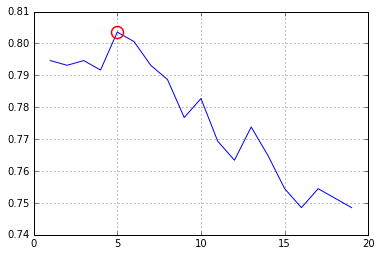

In [20]:
#Grid Search for best depth - Heavy
from sklearn.grid_search import GridSearchCV
ctree = tree.DecisionTreeClassifier(random_state=1)
depth_range = range(1, 20)
param_grid = dict(max_depth=depth_range)
grid = GridSearchCV(ctree, param_grid, cv=5)
grid.fit(X_train, y_train)
# Check out the scores of the grid search
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# Plot the results of the grid search
plt.figure()
plt.plot(depth_range, grid_mean_scores)
plt.hold(True)
plt.grid(True)
plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')